In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ncnn import NashCascadeNeuralNetwork as ncnn
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"

In [3]:

# Example
bucket_net = ncnn(cfg_file="./config.json")
bucket_net.initialize()


In [4]:
bucket_net.update_network()

In [5]:
bucket_net.summarize_network()

Initial Mass in network at start: 309.0
Final Mass in network: 45.9
Total Mass out of network 1012.1
Total precipitation into network 749.0
Final mass balance is -0.000
Final mass balance is -0.000


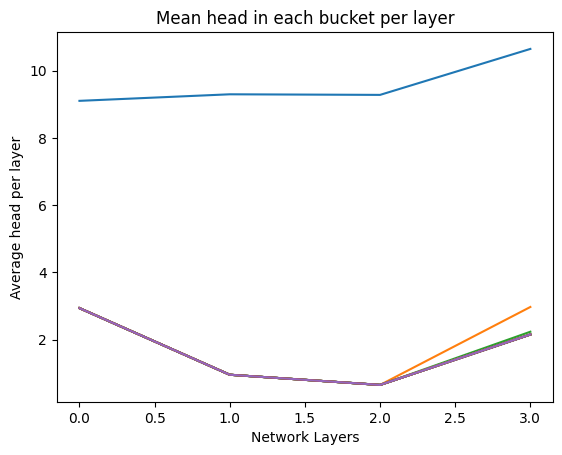

In [6]:
bucket_net.summarize_network()
inital_mass_in_network = np.sum(bucket_net.sum_H_per_layer)
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list = []
network_precip_input_list = []
count = 0
for i in range(15000):

    ###########################################################################
    if count > 950:
        network_precip_input_list.append(1)
    else:
        network_precip_input_list.append(0)
    if count == 1000:
        count = 0
    count+=1
    ###########################################################################

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, np.array(network_precip_input_list[-1]))
    network_outflow = bucket_net.update_network()
    network_outflow_list.append(bucket_net.network_outflow)
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

    if i % 1000 == 0:
        plt.plot(bucket_net.mean_H_per_layer)

###########################################################################
total_mass_precip_in = np.sum(network_precip_input_list)
final_mass_in_network = np.sum(bucket_net.sum_H_per_layer)
total_mass_outflow = np.sum(network_outflow_list)
print(f"Final Mass in network: {final_mass_in_network:.1f}")
print(f"Total Mass out of network {total_mass_outflow:.1f}")
print(f"Total precipitation into network {total_mass_precip_in:.1f}")
mass_balance = (inital_mass_in_network + total_mass_precip_in) - (final_mass_in_network + total_mass_outflow)
print(f"Final mass balance is {mass_balance:.3f}")
mass_balance = (inital_mass_in_network - final_mass_in_network) - (total_mass_outflow - total_mass_precip_in)
print(f"Final mass balance is {mass_balance:.3f}")
plt.title("Mean head in each bucket per layer")
plt.ylabel("Average head per layer")
plt.xlabel("Network Layers")
plt.show()
plt.close()

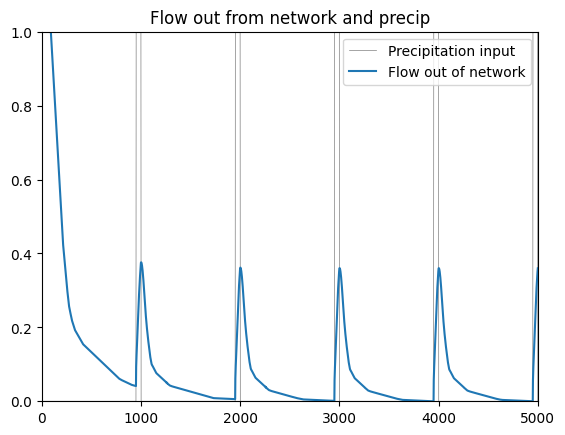

In [7]:
startplt = 0#int(len(network_outflow_list)-(len(network_outflow_list)/2))
endplt = int(len(network_outflow_list)/3)
plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
plt.plot(network_outflow_list, label="Flow out of network")
plt.xlim([startplt, endplt])
plt.ylim([0, np.max(np.array(network_precip_input_list)[startplt:endplt])])
plt.legend()
plt.title("Flow out from network and precip")
plt.show()
plt.close()